## Forecasting

There are different approachs.

### Naive approach

The last value will be the same as the previous value.

## How to measure performance 

There are different approachs

### Fixed partitioning

We split the time series into three parts: trainining-validation-testing, into contiguous times (not random). The process: we train with training and evaluate with validation to choose arquitecture and set up hyperparameters; then we measure performance on new data on testing-dataset. Finally we train with all the data (three parts) to create our productive model.

A more flexible version of this method is only to use a partition training-validation. We don't have testing dataset, but we run test of performance later with real new data in production.

### Roll forward partitioning

We perform several times fixed partitioning, increasing gradually (by day, by week) our train set, and forecasting on the subsequent period of the validation set (example, a week.)

### Moving Average

We calculate the next value as the moving average of the previous n values (averaging window).

This method eliminate most of noise, but it doesn't anticipate trends or seasonalities.

For this reason, the common procedure is to differentiate a serie to separate trend and seasonality, then to execute prediction, and finally add the result on the original trend, seasonality.

We can use moving average using **centered windows** o **trailing windows**.


## Differentiation

It is a way to separate trend and seasonality

## Measures to evaluating performance

### MSE (mean square error)

mse = np.square(errors).mean()

### RMSE (root mean square error)

rmse = np.sqrt(mse)

### MAE (Mean absolute error)

np.abs(errors).mean()

### MAPE (Mean absolute percentage error)

np.abs(errors/x_valid).mean()

## Examples

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-03-05 13:09:46.068551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 13:09:46.098951: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 13:09:46.222606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 13:09:46.222668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 13:09:46.239392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
# --- BASICS ---
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

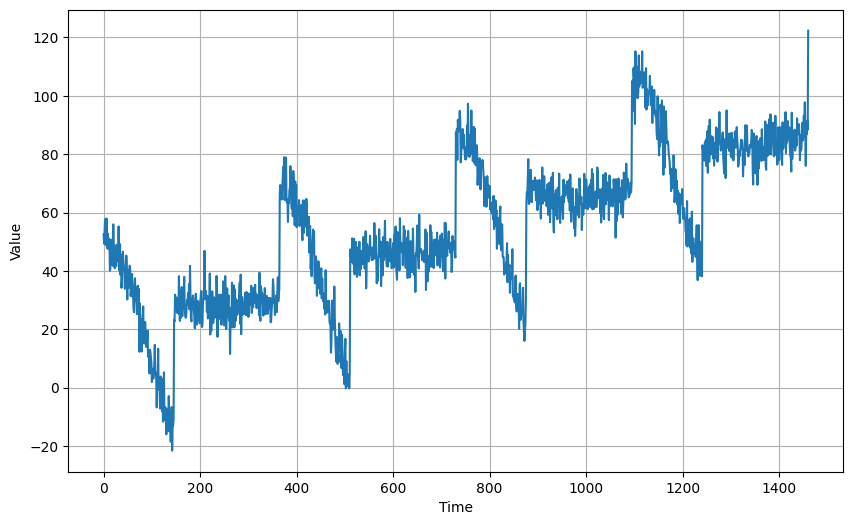

In [5]:
# --- We create synthetic data ----
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [7]:
# --- SPLIT ---

# The split method is fixed partitioning
# Define the split time
# train: hasta el dia 1000. Valid: después del día 1000.
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

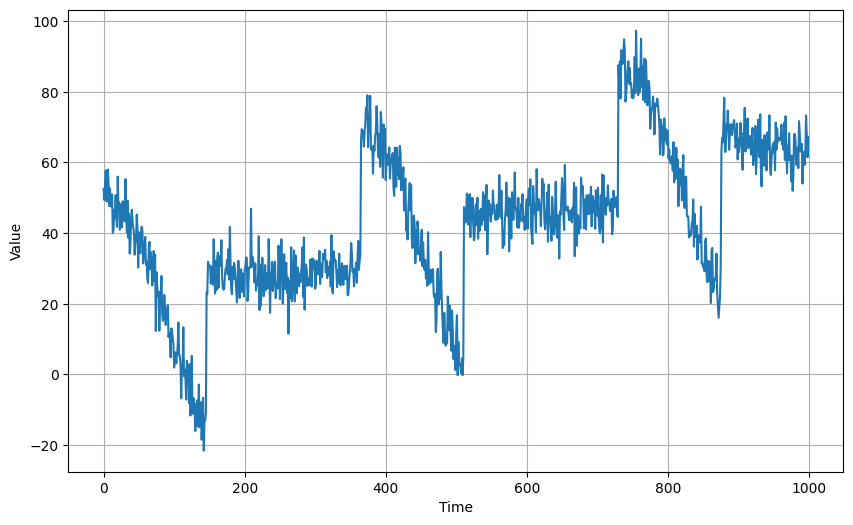

In [8]:
# Plot the train set
plot_series(time_train, x_train)

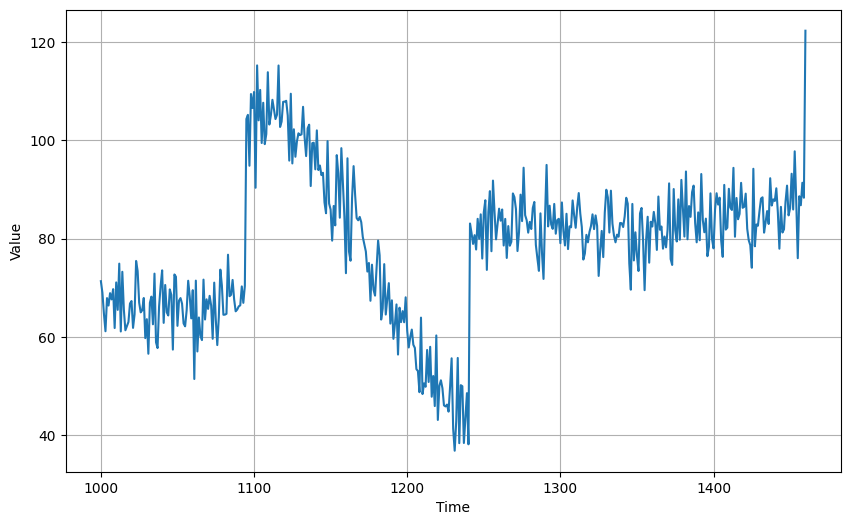

In [9]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [13]:
# --- FORECAST: NAIVE ---
# Generate the naive forecast: predicted value is equal to previous.
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

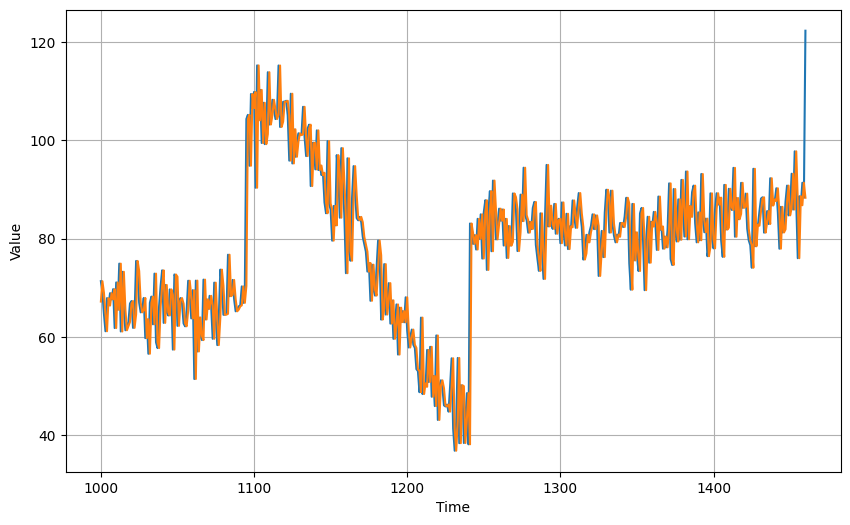

In [14]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

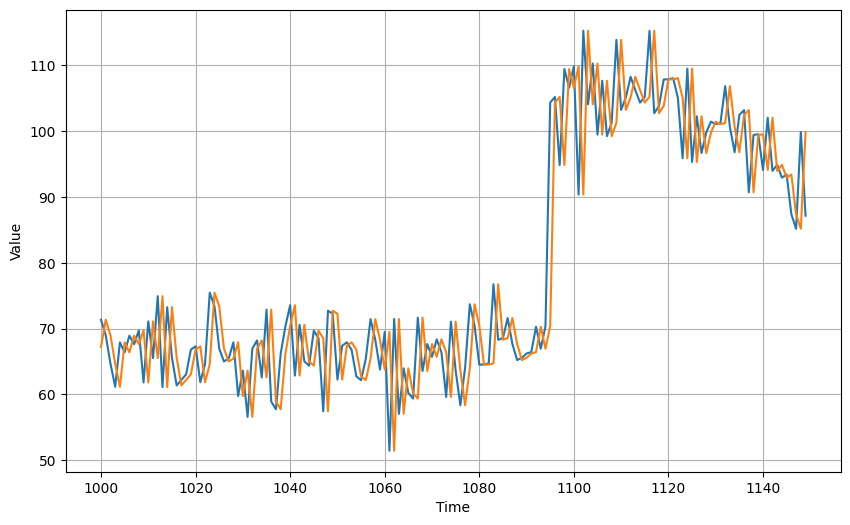

In [15]:
# Zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

In [18]:
# metrics
mse_1 = tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae_1 = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print(f"MSE model 1: {mse_1}")
print(f"MAE model 1: {mae_1}")

MSE model 1: 61.82753311976389
MAE model 1: 5.937908311029847


In [20]:
# --- FORECAST: MOVING AVERAGE ---

def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    # windows = (1,5) (2,6), ...etc. para window size = 4.
    # lo importante aca es que el ma se hace con el bucle for directamente.
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

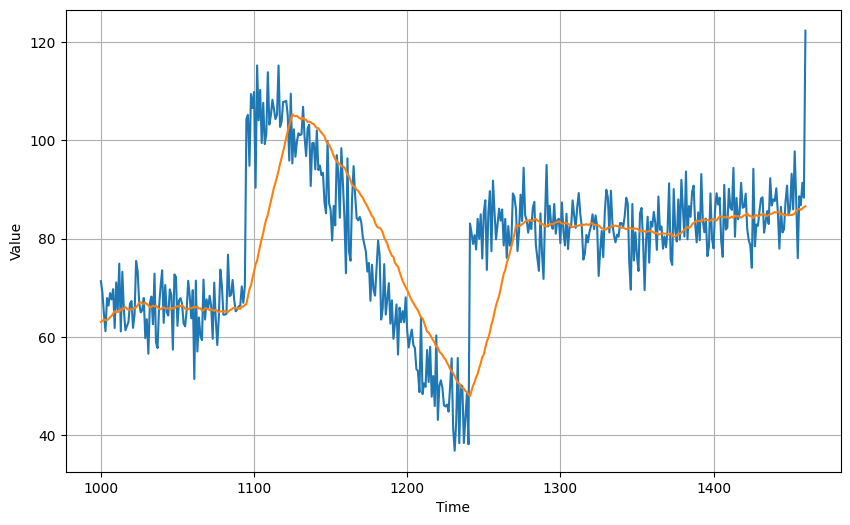

In [21]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [22]:
# metrics

# El segundo model va pero que el primero
mse_1 = tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae_1 = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print(f"MSE model 1: {mse_1}")
print(f"MAE model 1: {mae_1}")

mse_2 = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
mae_2 = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print(f"MSE model 2: {mse_2}")
print(f"MAE model 2: {mae_2}")

MSE model 1: 61.82753311976389
MAE model 1: 5.937908311029847
MSE model 2: 106.67456946897563
MAE model 2: 7.142418784295038


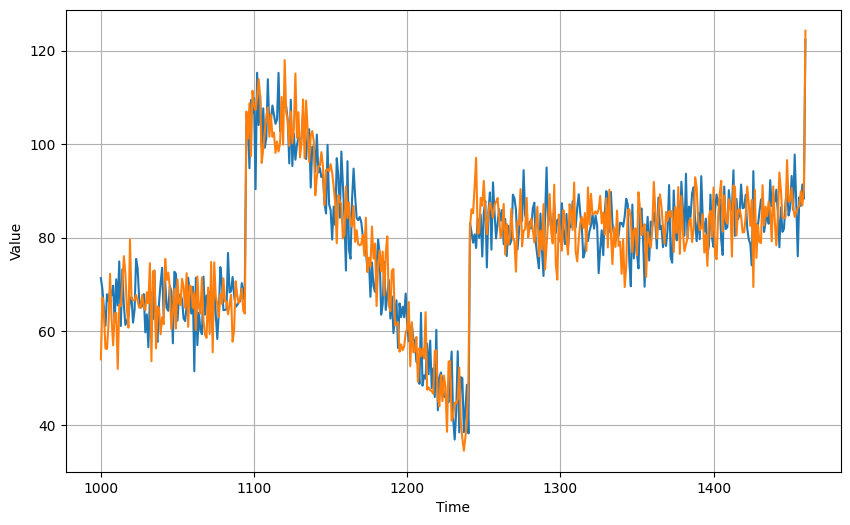

In [25]:
# --- FORECASTING MV sin estacionalidad ---

# Subtract the values at t-365 from original series
# elimino estacionalidad
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
# plot_series(diff_time, diff_series)

# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
# plot_series(time_valid, (diff_series, diff_moving_avg))

# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [26]:
# metrics

# El segundo model va pero que el primero
# El tercero da ligeramente mejor que el primero
mse_1 = tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae_1 = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print(f"MSE model 1: {mse_1}")
print(f"MAE model 1: {mae_1}")

mse_2 = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
mae_2 = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print(f"MSE model 2: {mse_2}")
print(f"MAE model 2: {mae_2}")

mse_3 = tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()
mae_3 = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
print(f"MSE model 3: {mse_3}")
print(f"MAE model 3: {mae_3}")

MSE model 1: 61.82753311976389
MAE model 1: 5.937908311029847
MSE model 2: 106.67456946897563
MAE model 2: 7.142418784295038
MSE model 3: 53.764583056157086
MAE model 3: 5.903241584435017


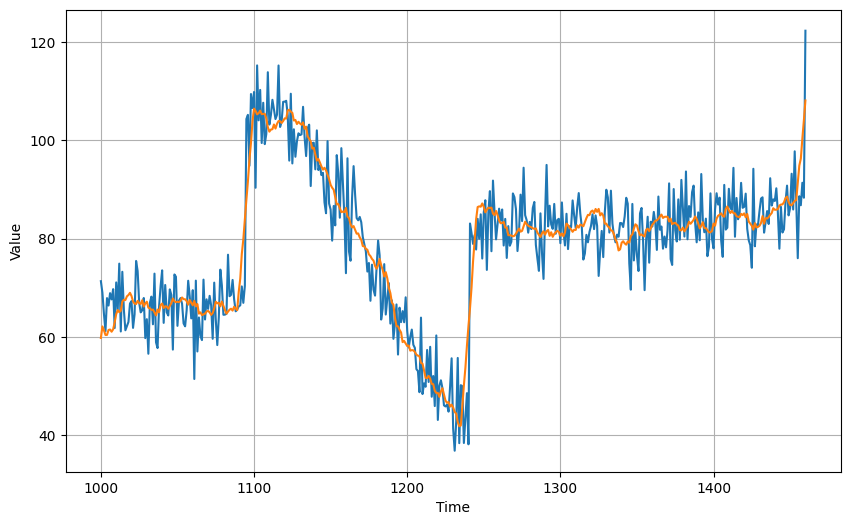

In [27]:
# --- FORECASTING: MA V.3 ---
# Sobre la serie original, con smooth, agrego el diff_mov_avg
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

In [28]:
# metrics

# El segundo model va pero que el primero
# El tercero da ligeramente mejor que el primero
# El cuarto da bastante mejor que los anteriores y es el ganador.
mse_1 = tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae_1 = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print(f"MSE model 1: {mse_1}")
print(f"MAE model 1: {mae_1}")

mse_2 = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
mae_2 = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print(f"MSE model 2: {mse_2}")
print(f"MAE model 2: {mae_2}")

mse_3 = tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()
mae_3 = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
print(f"MSE model 3: {mse_3}")
print(f"MAE model 3: {mae_3}")

mse_4 = tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
mae_4 = tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
print(f"MSE model 4: {mse_4}")
print(f"MAE model 4: {mae_4}")

MSE model 1: 61.82753311976389
MAE model 1: 5.937908311029847
MSE model 2: 106.67456946897563
MAE model 2: 7.142418784295038
MSE model 3: 53.764583056157086
MAE model 3: 5.903241584435017
MSE model 4: 34.315722788781734
MAE model 4: 4.605328958960493
